## Selecting formation and trading period from the whole timefrime
- main run function will be using this logic

In [ ]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
import math 
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import combinations


### Formation period functions ### 
def normalize(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert stock price series into cumulative return with 1 as a starting value.
    """
    # Only normalize using the first valid price (starting trading date differs for some stocks)
    df_result = df/df.iloc[0,:]
    return df_result

def calculate_and_sort_ssd(stocks: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate sum of squared differences (SSD) for all unique pairs of stocks and sort them.

    Parameters:
    stocks : pd.DataFrame
        Normalized stock dataframe scaled to 1 at the start for each stock.

    Returns:
    pd.DataFrame
        Sorted dataframe containing all possible stock pairs with their SSD values.
    """

    stock_pairs = list(combinations(stocks.columns, 2))  # Unique stock pairs
    ssd_values = {}

    for ticker1, ticker2 in tqdm(stock_pairs, desc="Calculating SSDs"):
        
        # Assign stock price series 
        stock1, stock2 = stocks[ticker1], stocks[ticker2]
        
        # If the stock is not trading yet, skip this pair. 
        if stock1.isna().any() or stock2.isna().any():
            continue
        
        # Compute SSD 
        spread = stock1 - stock2
        ssd = np.sum(np.square(spread)) 

        # Store directly in a dictionary
        ssd_values[f"{ticker1}_{ticker2}"] = ssd  

    # Convert dictionary to DataFrame (much faster than appending)
    df_result = pd.DataFrame.from_dict(ssd_values, orient="index", columns=["SSD"])

    return df_result.sort_values(by="SSD")

def select_cointegrated_pairs(stocks: pd.DataFrame, pairs: pd.DataFrame) -> pd.DataFrame:
    """
    Test for cointegration using the engle-granger two step procedure. Continue until 20 pairs are found. This portfolio will 
    be traded for the next 6 months.

    Parameters: 
    stocks: normalized stocks dataframe, a 12 month subset (formation period)  with a date column as an index
    pairs: all possible pairs ordered by ssd

    Returns: 
    porftolio: a portfolio of 20 stocks to be traded in the following 6 months 
    """

    portfolio = pd.DataFrame()
    pair_count = 0
    
    for pair in pairs.index:
        stock1, stock2 = pair.split("_")
        print(100 * "-", "\nProcessing pair:", stock1, "-", stock2)

        # Step 1: OLS of stock2 on stock1 (without constant)
        data = pd.concat([stocks[stock1], stocks[stock2]], axis=1).dropna()  # Drop NaN values
        x = data[stock1]  # No sm.add_constant()
        y = data[stock2]

        try:
            model = sm.OLS(y,x).fit()
            print("fitting ols....")
        except Exception as e:
            print(f"Error during OLS fit: {e}")

        ols_pvalue = model.pvalues.iloc[0]
        print("OLS p-values:\n", model.pvalues)
        print("\n",ols_pvalue)
       
        # if there is no linear relationship, continue
        if ols_pvalue > 0.05 or math.isnan(ols_pvalue): 
            print("NO OLS FIT...")
            continue 
        
        print("OLS FIT FOUND....")
        
        # Step 2 : dickey Fuller test of the residuals (the spread)
        residuals = pd.Series(model.resid)

        # Check stationarity
        try:
            adf_pvalue = adfuller(residuals)[1]
            print("ADF p value: " ,adf_pvalue)
        except Exception as e:
            print(f"Error during ADF test: {e}")

        # if stationary, select that pair as cointegrated, extract Beta, and parameters and add to the portfolio
        if  adf_pvalue < 0.05 and not np.isnan(adf_pvalue):
            print("Pair was selected and added to the portfolio!")
            # Assign to DataFrame
            portfolio.loc[pair, 'beta'] = model.params.iloc[0]
            portfolio.loc[pair, 'mean'] = np.mean(residuals)
            portfolio.loc[pair, 'sd'] = np.std(residuals)
            pair_count += 1
        else: 
            print("non-stationary series!...")
        
        if pair_count == 20:
            print(100*"X", "\n portfolio of 20 was selected")
            break

        print("\n pair count is :", pair_count) 
        
    return portfolio 

### Trading period functions ###
def calculate_portfolio_spread(stocks: pd.DataFrame, portfolio: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates spread and normalized spread for all 20 pairs of the portfolio based on the beta coefficient and parameters 
    estimated during the formation period.

    Params: 
    stocks: 6 month trading period stock dataframe.
    portfolio: contains 20 pairs of stocks to trade along with the parameters from the formation period.

    Returns: 2 dataframes, spread and normalized spread dataFrame for the trading period
    """
     # Initialize the DataFrames with the correct structure.
    spread_df = pd.DataFrame(index=stocks.index)  # Set the index to match the stocks DataFrame
    spread_df_normalized = pd.DataFrame(index=stocks.index)  # Same as above
    
    for pair in portfolio.index:
        #Extract the parameters from the formation period 
        beta,mean,sd = portfolio.loc[pair] 
        
        # Extract the tickes 
        stock1, stock2 = pair.split("_")   
             
        # Calculate spread series using beta 
        spread = stocks[stock2] - beta * stocks[stock1]
        spread_normalized = (spread - mean) / sd

        spread_df[pair] = spread
        spread_df_normalized[pair] = spread_normalized

    return spread_df, spread_df_normalized

def trade_portfolio(spread_df: pd.DataFrame, spread_df_normalized: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the trading period spread of the selected pairs from the formation period
    Also calculate the normalized spread using the portfolio parameters.

    Parameters: 
    spread_df: the trading period spread of the 20 pairs (6 months)
    spread_df_normalized: the trading period spread normalized of the 20 pairs (6 months)

    Returns: 
    DataFrame containing the returns (from period t to t+n) if a trade was entered and exited.
    """
    result_df = pd.DataFrame(index = spread_df.index)

    for pair, pair_norm in zip(spread_df.columns,spread_df_normalized.columns):
        pair_result = {}
        entered_trade = False
        spread_t_norm = 0
        round_trip_count = 0
        print("proccesing pair: \n",  pair, "\n", 100*"-")
        
        for i in range(0,len(spread_df.index)):
            date = spread_df[pair].index[i]
            spread_current = spread_df[pair].iloc[i].item()
            spread_norm_current = spread_df_normalized[pair_norm].iloc[i].item()
            
            print(40*"-", "\nprocessing date", date)
            print("Current spread is: ",  spread_current, "and Current norm spread is",spread_norm_current)

            if abs(spread_norm_current) > 2 and not entered_trade:
                print("Trade was entered...")
                # when signal comes, save the variables at time t and enter trade
                entered_trade = True
                spread_t = spread_current
                spread_t_norm = spread_norm_current
                print("Current spread is: ",  spread_current, "and Current norm spread is",spread_norm_current)

            # if the spread at time t was > 2 and 
            # current spread returns to 0, exit and save delta_spread = spread_t+n - spread_t
            if spread_t_norm > 2 and spread_norm_current <= 0 and entered_trade:
                print("Trade was exited...")    
                entered_trade = False   # exit trade
                delta_spread = abs(spread_current - spread_t) # return = delta spread
                round_trip_count +=1 # trade count
            elif spread_t_norm < 2 and spread_norm_current >= 0 and entered_trade: # spread_t_nrom < -2 !!! 
                print("Trade was exited...")    
                entered_trade = False   # exit trade
                delta_spread = abs(spread_current - spread_t)
                round_trip_count +=1
            else: 
                # if trade is not entered or spread of the entered trade did not return to 0
                delta_spread = 0.0 

            # on the last day of trading, if the spread did not converge, exit the position in loss
            if date == spread_df.index[len(spread_df.index)-1]:
                print("\n LAST DAY OF THE TRADING....",date)
                if entered_trade == True:
                    print("the loss is spread_current - spread_t =",  abs(spread_current - spread_t), "current and t spread are: ", spread_current,spread_t)
                    delta_spread = - abs(spread_current - spread_t)
                    
            # Save the delta spread
            pair_result[date] = delta_spread
        
        # append to result df 
        result_df[pair] = pair_result
        print("\n number of completed round trip trades: ", round_trip_count, "\n",100*"-")    
    
    return result_df


In [ ]:

#stocks = pd.read_csv("~/OneDrive/Desktop/Jakub/masterThesis/stocks.csv")
stocks = pd.read_csv("C:/Users/adamt/OneDrive - Wirtschaftsuniversität Wien - IT-SERVICES/Desktop/masterThesis/stocks.csv",index_col = 0)
stocks = stocks[stocks.index >= "2022-01-01"]
stocks.index = pd.to_datetime(stocks.index)



def run_strategy_hossein(stocks: pd.DataFrame):
    time_frame = stocks.index

    months = pd.Series(time_frame).dt.to_period('M').unique()  # Extract unique months

    # This is the main dataframe, that stores the daily returns of each portfolio 
    returns_dictionary = {}

    n_trading_periods = 0 

    # Iterate through months instead of days
    for start_idx in range(len(months)):

        formation_start = pd.Timestamp(months[start_idx].start_time)
        formation_end = formation_start + pd.DateOffset(months=12)-pd.DateOffset(days=1)  # 12 months later
        trading_start = formation_start + pd.DateOffset(months=12)
        trading_end = formation_end + pd.DateOffset(months=6)  # Next 6 months
        
        # Ensure we don't exceed the timeframe
        if trading_end > time_frame[-1]:
            break
        
        # The backtest algorithm starts here:
        # 1. normalize the stock data at the start of the formation period to 1$  
        stocks_normalized = normalize(stocks.loc[formation_start:trading_end])

        # Select formation period data   
        stocks_formation = stocks_normalized.loc[formation_start:formation_end]
        # Select testing data (next 6 months)
        stocks_trading = stocks_normalized.loc[trading_start:trading_end]

        print(f"Formation Start:\n{stocks_formation.index[0]}")
        print("X" * 80)
        
        # Formation part 
        # 2. sort by ssd ~ 1 minute
        print("\nSorting all combinations by SSD...\n")
        print("=" * 80)
        pairs_sorted = calculate_and_sort_ssd(stocks_formation)

        # 3. Select 20 cointegrated pairs 
        print("\nSelecting cointegrated pairs using Engle-Kranger method...\n")
        print("=" * 80)
        portfolio = select_cointegrated_pairs(stocks_formation, pairs_sorted)

        print(f"Formation End:\n{stocks_formation.index[-1]}")
        print("-" * 80)

        print(f"Trading Start:\n{stocks_trading.index[0]}")
        
        # Trading part 
        # 4. Calculate spread and normalized spread for all 20 pairs of the portfolio
        print("\nCalculating spread in the trading period...\n")
        print("=" * 80)
        spread_df, spread_df_norm = calculate_portfolio_spread(stocks_trading, portfolio)

        # 5. Trade portfolio
        print("\nPortfolio is trading...\n")
        print("=" * 80)
        result_df = trade_portfolio(spread_df, spread_df_norm)

        print(f"Trading End:\n{stocks_trading.index[-1]}\n")
        print("X" * 80)

        # 6. Calculate daily returns of each portfolio and append this column for each trading period
        # calculated as a row sums of the daily returns of 20 pairs 
        returns_dictionary[f"Portfolio_{trading_start}"] = result_df.sum(axis=1)
        n_trading_periods += 1
        print("Number of trading periods: ", n_trading_periods) 
    return returns_dictionary


backtest_result = run_strategy_hossein(stocks)

21.320006583574163
-22.454604902540012


(array([ 1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  2.,  3.,  0.,  1.,
         1.,  0.,  1.,  1.,  2.,  2.,  2.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  0., 65., 62., 20., 14.,  4.,  4.,  1.,  3.,  2.]),
 array([-2.72832557e+00, -2.66174800e+00, -2.59517043e+00, -2.52859286e+00,
        -2.46201528e+00, -2.39543771e+00, -2.32886014e+00, -2.26228257e+00,
        -2.19570499e+00, -2.12912742e+00, -2.06254985e+00, -1.99597228e+00,
        -1.92939470e+00, -1.86281713e+00, -1.79623956e+00, -1.72966199e+00,
        -1.66308441e+00, -1.59650684e+00, -1.52992927e+00, -1.46335169e+00,
        -1.39677412e+00, -1.33019655e+00, -1.26361898e+00, -1.19704140e+00,
        -1.13046383e+00, -1.06388626e+00, -9.97308687e-01, -9.30731114e-01,
        -8.64153541e-01, -7.97575969e-01, -7.30998396e-01, -6.64420823e-01,
        -5.97843251e-01, -5.31265678e-01, -4.64688106e-01, -3.98110533e-01,
        -3.31532960e-01, -2.6495

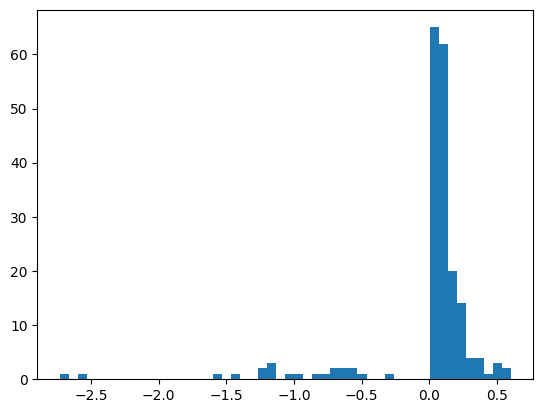

In [ ]:
#backtest_result.to_csv("C:/Users/adamt/OneDrive - Wirtschaftsuniversität Wien - IT-SERVICES/Desktop/masterThesis/test_files/backtestfrom2022_result.csv")
daily_returns = backtest_result.sum(axis=1)
daily_returns = daily_returns[daily_returns !=0]

print(sum(daily_returns[daily_returns>0]))
print(sum(daily_returns[daily_returns<0]))


plt.hist(daily_returns, bins = 50)


